In [2]:
from google.colab import files
uploaded = files.upload()

Saving vendas.csv to vendas.csv


In [3]:
import pandas as pd

# Tente com separador por ponto e vírgula
df = pd.read_csv('vendas.csv', sep=',', encoding='utf-8')

# Renomeia a primeira coluna para 'Data' se necessário
df.rename(columns={df.columns[0]: 'Data'}, inplace=True)

# Converte a coluna de data
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)


In [4]:
# Convertendo colunas numéricas (vírgulas para ponto)
colunas_numericas = df.columns.drop('Data')
for col in colunas_numericas:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remover linhas com valores faltantes
df.dropna(inplace=True)

# Criar coluna com número de dias desde o início
df['dias'] = (df['Data'] - df['Data'].min()).dt.days

# Criar coluna com dia da semana
df['dia_semana'] = df['Data'].dt.dayofweek  # Segunda=0, Domingo=6


In [5]:
print(df.columns.tolist())


['Data', 'Vendas Brutas Ajustadas', 'GCs', 'Ticket médio', 'Vendas liquidas acumuladas', 'GC´s acumulados', 'Ticket médio acumulado', 'dias', 'dia_semana']


In [6]:
# Definindo X e y com os nomes corretos
X = df[['dias', 'GCs', 'Ticket médio', 'dia_semana']]
y = df['Vendas Brutas Ajustadas']


In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Passo 1: Carregar o CSV ---
df = pd.read_csv('vendas.csv', sep=',', decimal=',')

# --- Passo 2: Renomear colunas para facilitar (ajuste conforme seu arquivo) ---
df.rename(columns={
    df.columns[0]: 'Data',
    'Vendas Brutas Ajustadas': 'Vendas_Brutas',
    'GCs': 'GCs',
    'Ticket médio': 'Ticket_medio',
    'Vendas liquidas acumuladas': 'Vendas_liquidas_acumuladas',
    'GC´s acumulados': 'GCs_acumulados',
    'Ticket médio acumulado': 'Ticket_medio_acumulado'
}, inplace=True)

# --- Passo 3: Converter a coluna Data para datetime ---
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# --- Passo 4: Converter colunas numéricas para float ---
cols_numericas = ['Vendas_Brutas', 'GCs', 'Ticket_medio',
                  'Vendas_liquidas_acumuladas', 'GCs_acumulados', 'Ticket_medio_acumulado']

for col in cols_numericas:
    # Remover pontos de milhar e substituir vírgula decimal por ponto
    df[col] = df[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# --- Passo 5: Criar variáveis auxiliares para modelo ---

# Criar coluna 'dias' (número de dias desde a menor data)
df['dias'] = (df['Data'] - df['Data'].min()).dt.days

# Criar coluna 'dia_semana' (segunda=0,...domingo=6)
df['dia_semana'] = df['Data'].dt.dayofweek

# --- Passo 6: Definir variáveis independentes (X) e dependente (y) ---
X = df[['dias', 'GCs', 'Ticket_medio', 'dia_semana']]
y = df['Vendas_Brutas']

# --- Passo 7: Separar dados treino e teste ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Passo 8: Treinar o modelo ---
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# --- Passo 9: Fazer previsões ---
y_pred = modelo.predict(X_test)

# --- Passo 10: Avaliar o desempenho ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # corrigido para evitar erro
r2 = r2_score(y_test, y_pred)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100

print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 2,548.25
RMSE: 3,576.97
R²: 0.8625
MAPE: 6.91%


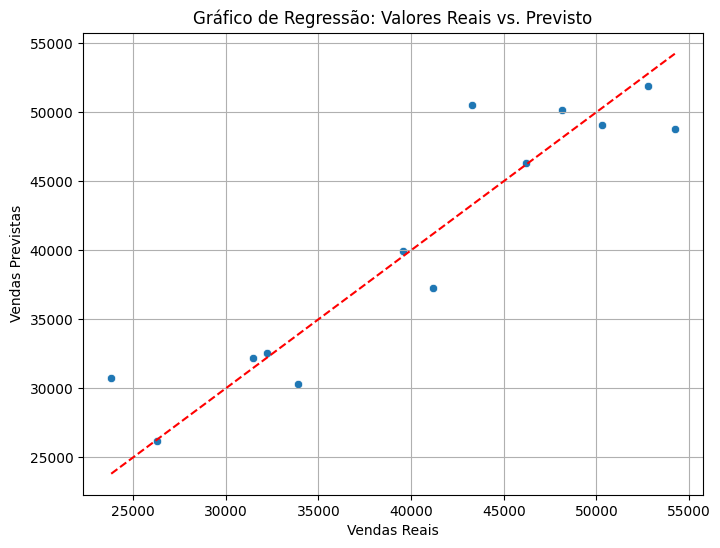

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linha de identidade
plt.xlabel('Vendas Reais')
plt.ylabel('Vendas Previstas')
plt.title('Gráfico de Regressão: Valores Reais vs. Previsto')
plt.grid(True)
plt.show()


In [9]:
import pandas as pd
import numpy as np

# Última data do dataset atual
ultima_data = df['Data'].max()

# Criar lista de datas futuras (60 dias)
datas_futuras = pd.date_range(start=ultima_data + pd.Timedelta(days=1), periods=60)

# Criar DataFrame das futuras datas
df_futuro = pd.DataFrame({'Data': datas_futuras})

# Criar colunas auxiliares usadas no modelo:
df_futuro['dias'] = (df_futuro['Data'] - df['Data'].min()).dt.days
df_futuro['dia_semana'] = df_futuro['Data'].dt.dayofweek

# Para as variáveis GCs e Ticket médio (que o modelo também usa), precisamos definir valores futuros.
# Se não tem como prever, você pode usar a média histórica como aproximação:

media_GCs = df['GCs'].mean()
media_Ticket = df['Ticket_medio'].mean()

df_futuro['GCs'] = media_GCs
df_futuro['Ticket_medio'] = media_Ticket

# Preparar X para previsão
X_futuro = df_futuro[['dias', 'GCs', 'Ticket_medio', 'dia_semana']]

# Fazer previsão
previsoes = modelo.predict(X_futuro)

# Adicionar as previsões no DataFrame futuro
df_futuro['Previsao_Vendas_Brutas'] = previsoes

print(df_futuro[['Data', 'Previsao_Vendas_Brutas']])


         Data  Previsao_Vendas_Brutas
0  2025-07-20            49311.893558
1  2025-07-21            34522.839835
2  2025-07-22            37027.810210
3  2025-07-23            39532.780585
4  2025-07-24            42037.750960
5  2025-07-25            44542.721336
6  2025-07-26            47047.691711
7  2025-07-27            49552.662086
8  2025-07-28            34763.608363
9  2025-07-29            37268.578738
10 2025-07-30            39773.549113
11 2025-07-31            42278.519488
12 2025-08-01            44783.489864
13 2025-08-02            47288.460239
14 2025-08-03            49793.430614
15 2025-08-04            35004.376891
16 2025-08-05            37509.347266
17 2025-08-06            40014.317641
18 2025-08-07            42519.288016
19 2025-08-08            45024.258391
20 2025-08-09            47529.228767
21 2025-08-10            50034.199142
22 2025-08-11            35245.145419
23 2025-08-12            37750.115794
24 2025-08-13            40255.086169
25 2025-08-1

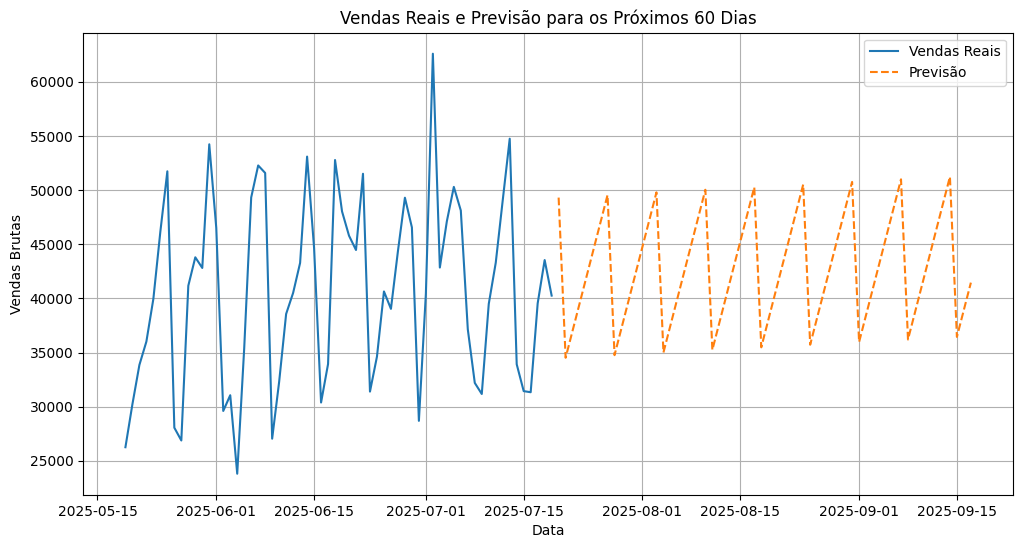

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Data'], df['Vendas_Brutas'], label='Vendas Reais')
plt.plot(df_futuro['Data'], df_futuro['Previsao_Vendas_Brutas'], label='Previsão', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Vendas Brutas')
plt.title('Vendas Reais e Previsão para os Próximos 60 Dias')
plt.legend()
plt.grid(True)
plt.show()


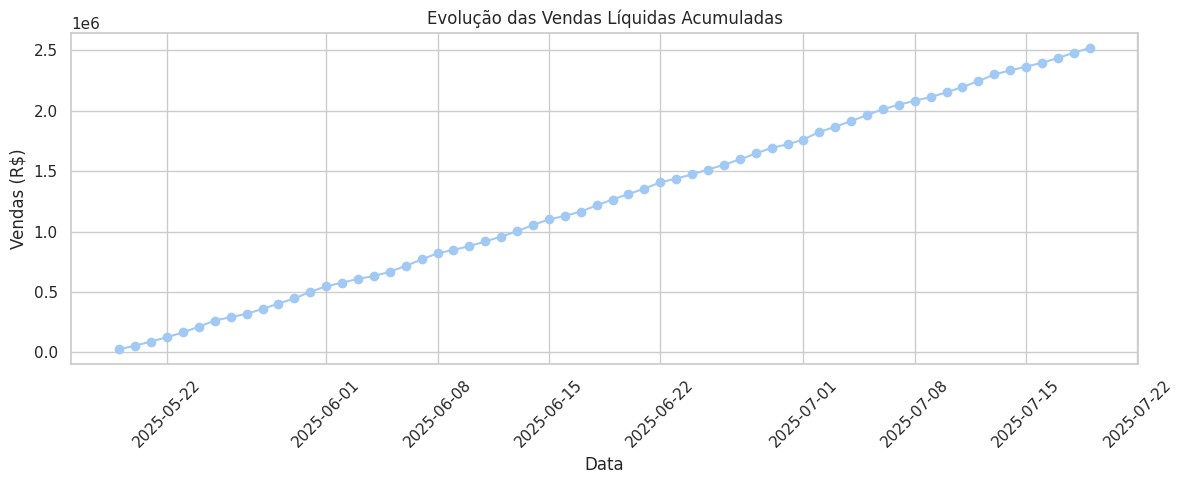

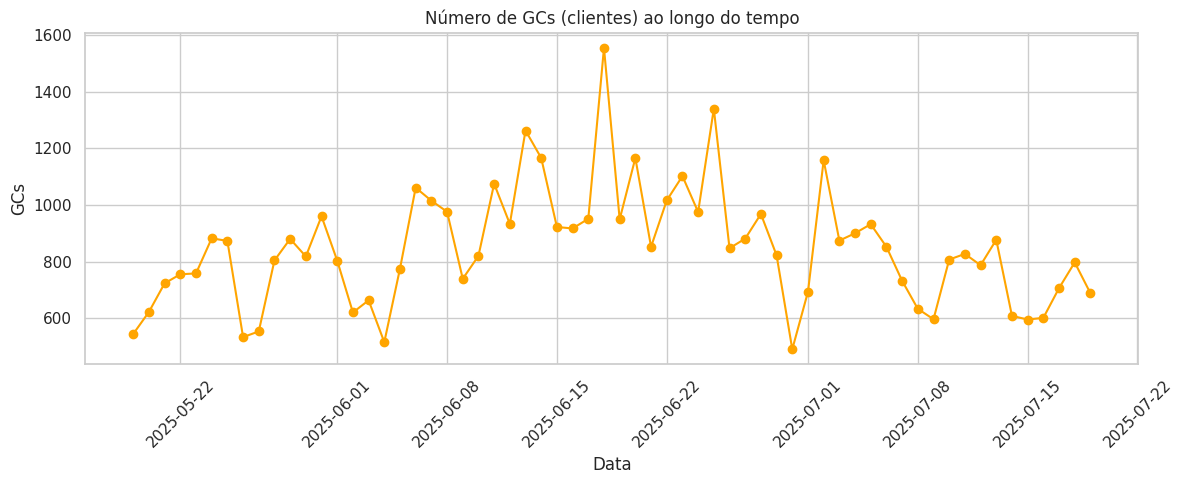

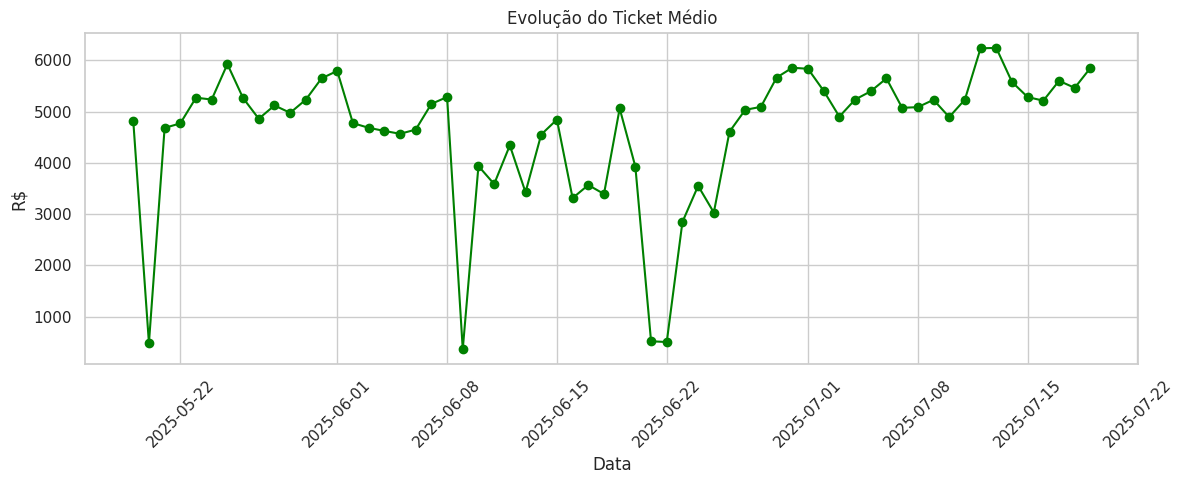

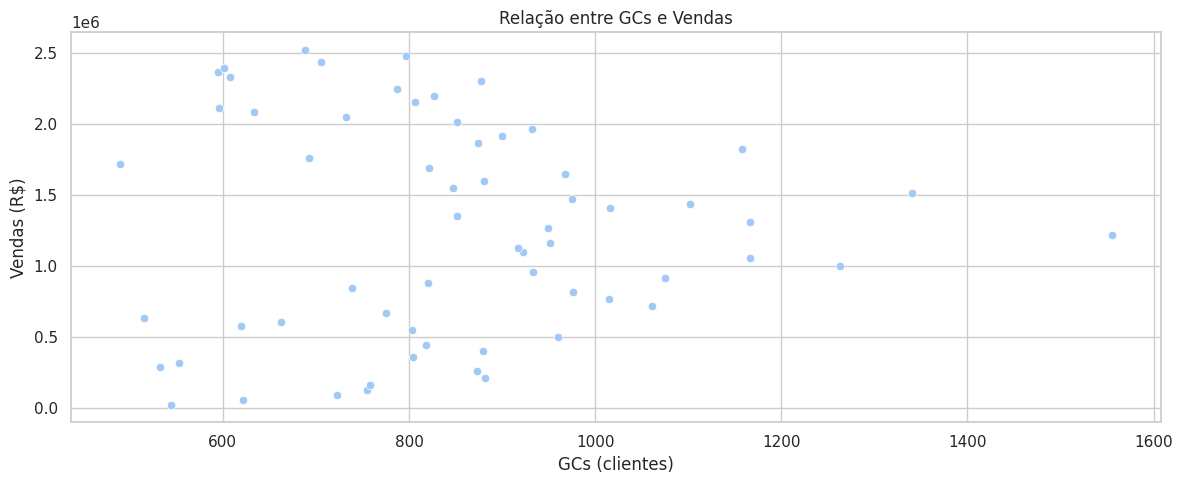

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
sns.set(style="whitegrid", palette="pastel")

# Tamanho fixo para os gráficos
plt.rcParams["figure.figsize"] = (12, 5)

# --- 1. Evolução das vendas ao longo do tempo ---
plt.plot(df["Data"], df["Vendas_liquidas_acumuladas"], marker='o')
plt.title("Evolução das Vendas Líquidas Acumuladas")
plt.xlabel("Data")
plt.ylabel("Vendas (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 2. Evolução dos GCs ao longo do tempo ---
plt.plot(df["Data"], df["GCs"], marker='o', color='orange')
plt.title("Número de GCs (clientes) ao longo do tempo")
plt.xlabel("Data")
plt.ylabel("GCs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 3. Evolução do Ticket Médio ao longo do tempo ---
plt.plot(df["Data"], df["Ticket_medio"], marker='o', color='green')
plt.title("Evolução do Ticket Médio")
plt.xlabel("Data")
plt.ylabel("R$")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 4. Correlação entre GCs e Vendas ---
sns.scatterplot(x="GCs", y="Vendas_liquidas_acumuladas", data=df)
plt.title("Relação entre GCs e Vendas")
plt.xlabel("GCs (clientes)")
plt.ylabel("Vendas (R$)")
plt.tight_layout()
plt.show()


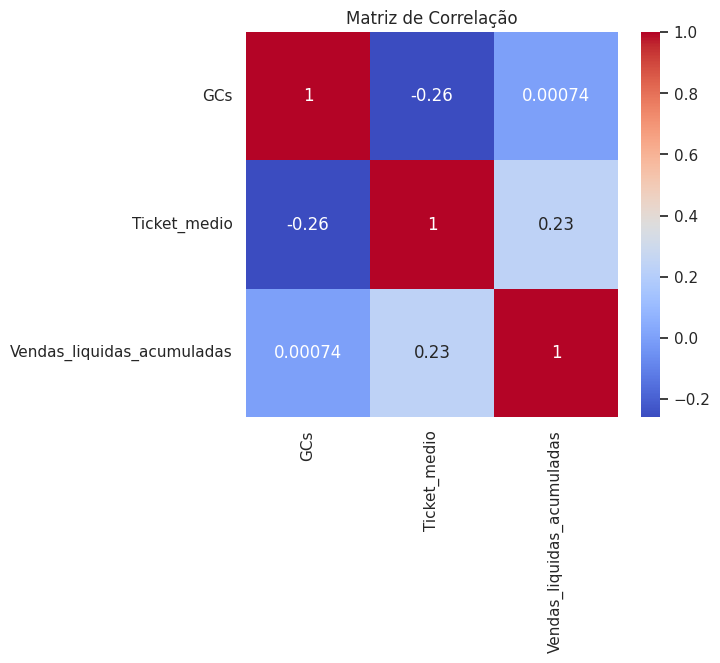

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlação
corr = df[["GCs", "Ticket_medio", "Vendas_liquidas_acumuladas"]].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

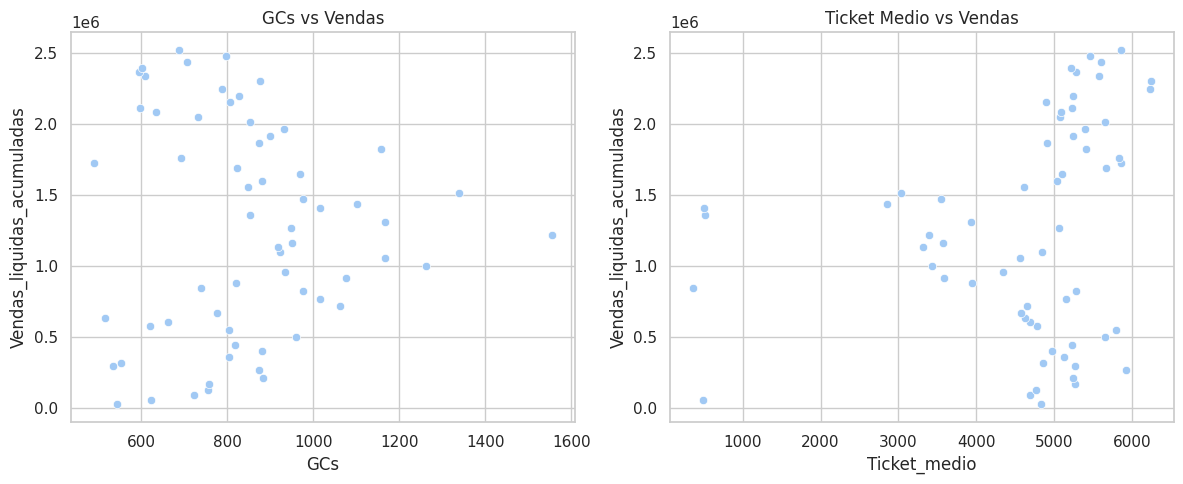

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sns.scatterplot(x="GCs", y="Vendas_liquidas_acumuladas", data=df, ax=axs[0])
axs[0].set_title("GCs vs Vendas")

sns.scatterplot(x="Ticket_medio", y="Vendas_liquidas_acumuladas", data=df, ax=axs[1])
axs[1].set_title("Ticket Medio vs Vendas")

plt.tight_layout()
plt.show()


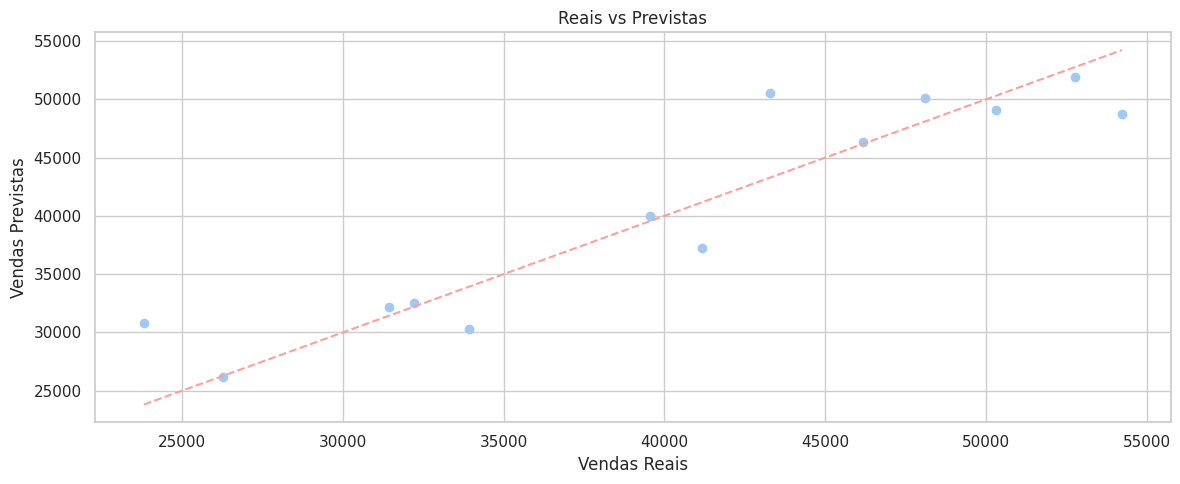

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Vendas Reais")
plt.ylabel("Vendas Previstas")
plt.title("Reais vs Previstas")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()